In [1]:
import matplotlib.pyplot as plt
import random
import urllib

# Download a large enough body of text

In [2]:
raw_text = urllib.request.urlopen("https://gutenberg.net.au/ebooks02/0200051.txt").read()

In [3]:
def clean(text):
    return "".join( ch for ch in text.upper() if 'A' <= ch <= 'Z' )

In [4]:
clean_text = clean(raw_text.decode("utf-8", errors="ignore"))

In [5]:
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

In [6]:
def compute_frequencies(text):
    f = { ch : 0 for ch in alphabet }
    
    for ch in text:
        f[ch] += 1
    
    for ch in alphabet:
        f[ch] /= len(text)
    
    return f

In [7]:
english_frequencies = compute_frequencies(clean_text)

In [8]:
def plot(f):
    plt.bar( f.keys(),  f.values() )

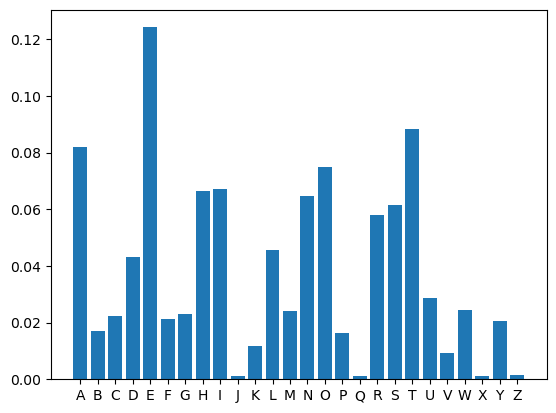

In [9]:
plot(english_frequencies)

# Shift ciphers

In [10]:
def shift_char(ch, shift):
    return  chr( ord("A") + (ord(ch) - ord("A") + shift)%26   )

In [11]:
def ss_encrypt(message, key):
    return "".join( shift_char(ch, key) for ch in message )

In [12]:
ss_encrypt("TESTSTRING", 1)

'UFTUTUSJOH'

In [13]:
def ss_decrypt(ciphertext, key):
    return "".join( shift_char(ch, -key) for ch in ciphertext )

In [14]:
ss_decrypt("UFTUTUSJOH", 1)

'TESTSTRING'

# Breaking Shift Ciphers

In [15]:
# Read a plaintext to be encrypted with a secret key
with open("plaintext1.txt", "r") as f:
    challenge_message = clean(f.read())

In [16]:
secret_key = random.randint(1, 25)

In [17]:
challenge_ciphertext = ss_encrypt(challenge_message, secret_key)

In [20]:
#Alternatively, read a challenge from a file
#with open("challenge1.txt", "r") as f:
#    challenge_ciphertext = clean(f.read())

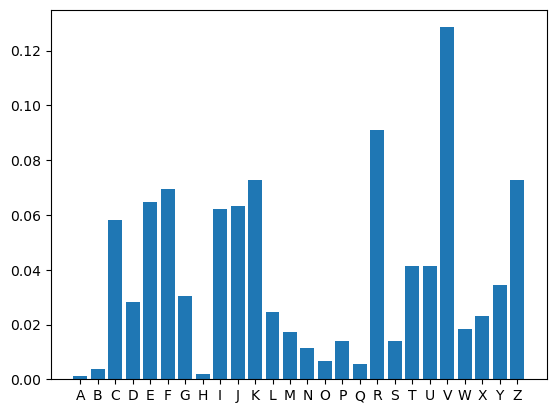

In [18]:
plot( compute_frequencies(challenge_ciphertext) )

In [19]:
def compute_pq(p, q):
    return sum( p[ch] * q[ch]  for ch in alphabet ) 

In [20]:
def shift_freq_left(f, shift):
    return { ch : f[ shift_char(ch, shift) ]  for ch in alphabet }

In [21]:
def ss_break(c):
    expected_psquared = compute_pq(english_frequencies, english_frequencies)
    ciphertext_frequencies = compute_frequencies(c)
    
    best_shift = None
    best_error = 1000
    for shift in range(0, 26):
        pq = compute_pq(english_frequencies, shift_freq_left(ciphertext_frequencies, shift) )
        error = abs( pq - expected_psquared )
        
        if error < best_error:
            best_error = error
            best_shift = shift
    
    return best_shift

In [22]:
guessed_key = ss_break( challenge_ciphertext )

In [23]:
guessed_key

17

In [24]:
decoded_plaintext = ss_decrypt( challenge_ciphertext, guessed_key )

In [25]:
decoded_plaintext

'PORTALISAPUZZLEPLATFORMGAMEDEVELOPEDANDPUBLISHEDBYVALVEITWASRELEASEDINABUNDLETHEORANGEBOXFORWINDOWSXBOXANDPLAYSTATIONANDHASBEENSINCEPORTEDTOOTHERSYSTEMSINCLUDINGMACOSXLINUXANDROIDVIANVIDIASHIELDANDNINTENDOSWITCHPORTALCONSISTSPRIMARILYOFASERIESOFPUZZLESTHATMUSTBESOLVEDBYTELEPORTINGTHEPLAYERSCHARACTERANDSIMPLEOBJECTSUSINGTHEAPERTURESCIENCEHANDHELDPORTALDEVICEALSOREFERREDTOASTHEPORTALGUNADEVICETHATCANCREATEINTRASPATIALPORTALSBETWEENTWOFLATPLANESTHEPLAYERCHARACTERCHELLISCHALLENGEDANDTAUNTEDBYANARTIFICIALINTELLIGENCENAMEDGLADOSGENETICLIFEFORMANDDISKOPERATINGSYSTEMTOCOMPLETEEACHPUZZLEINTHEAPERTURESCIENCEENRICHMENTCENTERUSINGTHEPORTALGUNWITHTHEPROMISEOFRECEIVINGCAKEWHENALLTHEPUZZLESARECOMPLETEDTHESOURCEENGINESPHYSICSSYSTEMALLOWSKINETICENERGYTOBERETAINEDTHROUGHPORTALSREQUIRINGCREATIVEUSEOFPORTALSTOMANEUVERTHROUGHTHETESTCHAMBERSTHISGAMEPLAYELEMENTISBASEDONASIMILARCONCEPTFROMTHEGAMENARBACULARDROPMANYOFTHETEAMMEMBERSFROMTHEDIGIPENINSTITUTEOFTECHNOLOGYWHOWORKEDONNARBACULARDROPWEREHIREDBYVALVEFORT

In [26]:
#If we encrypted the plaintext ourselves, we can check whether we recovered the right key...
guessed_key == secret_key

True

In [27]:
#... and the right plaintext
decoded_plaintext == challenge_message

True

# Vigenère Cipher

In [28]:
def vigenere_encrypt(message, key):
    ciphertext = ""
    for i in range(0, len(message)):
        ciphertext += shift_char( message[i], ord(key[ i % len(key) ]) - ord("A") )
    
    return ciphertext

In [29]:
def vigenere_decrypt(ciphertext, key):
    plaintext = ""
    for i in range(0, len(ciphertext)):
        plaintext += shift_char( ciphertext[i], - ( ord(key[ i % len(key) ]) - ord("A") ) )
    
    return plaintext

In [30]:
vigenere_encrypt("TESTING", "ABC")

'TFUTJPG'

In [31]:
vigenere_decrypt("TFUTJPG", "ABC")

'TESTING'

## Breaking the Vigenère cipher

In [32]:
# Read a plaintext to be encrypted with a secret key
with open("plaintext2.txt", "r") as f:
    challenge_message = clean(f.read())

In [33]:
secret_key_length = random.randint(3, 20)

In [34]:
secret_key = "".join(  random.choice(alphabet)  for i in range(secret_key_length)  )

In [35]:
challenge_ciphertext = vigenere_encrypt(challenge_message, secret_key)

In [37]:
#Alternatively, read a challenge from a file
#with open("challenge2.txt", "r") as f:
#    challenge_ciphertext = clean(f.read())

### Finding the key length

In [36]:
def vigenere_break_key_len(c):
    expected_psquared = compute_pq(english_frequencies, english_frequencies)
    result = {}
    for key_len_guess in range(1, 20):
        sub_c = c[::key_len_guess]
        f = compute_frequencies(sub_c)
        psquared = compute_pq(f, f)
        error = abs( psquared - expected_psquared )
        
        #print(key_len_guess, psquared, error)
        result[key_len_guess] = psquared
    return result

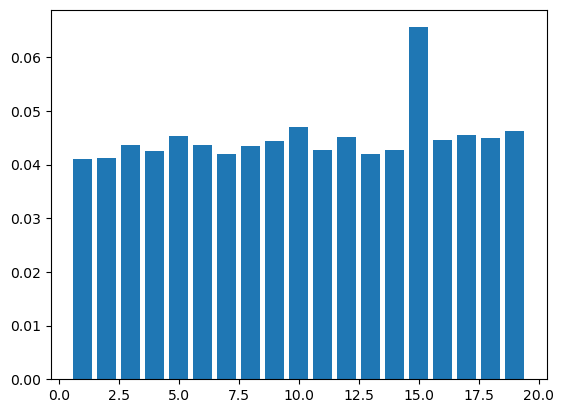

In [37]:
plot( vigenere_break_key_len(challenge_ciphertext) )

In [39]:
# Guess the correct key length according to the above plot
guessed_key_length = 15

### Breaking the cipher

In [43]:
sub_ciphertexts = [  challenge_ciphertext[i::guessed_key_length] for i in range(guessed_key_length)  ] 

In [44]:
guessed_key = "".join( chr( ss_break( sc )  + ord("A") )  for sc in sub_ciphertexts )

In [45]:
guessed_key

'ZQQFQXDMTSRQNVZ'

In [46]:
vigenere_decrypt( challenge_ciphertext, guessed_key )

'NEVERGONNAGIVEYOUUPISASONGBYENGLISHSINGERRICKASTLEYRELEASEDONJULYWRITTENANDPRODUCEDBYSTOCKAITKENWATERMANITWASRELEASEDBYRCARECORDSASTHEFIRSTSINGLEFROMASTLEYSDEBUTSTUDIOALBUMWHENEVERYOUNEEDSOMEBODYTHESONGBECAMEAWORLDWIDEHITINITIALLYINTHEUNITEDKINGDOMINWHEREITSTAYEDATTHETOPOFTHECHARTFORFIVEWEEKSANDWASTHEBESTSELLINGSINGLEOFTHATYEARITEVENTUALLYTOPPEDCHARTSINDIFFERENTCOUNTRIESINCLUDINGTHEUNITEDSTATESANDWESTGERMANYANDWINNINGBESTBRITISHSINGLEATTHEBRITAWARDSTHESONGISWIDELYREGARDEDASASTLEYSMOSTPOPULARASWELLASHISSIGNATUREANDITISOFTENPLAYEDATTHEENDOFHISLIVECONCERTSTHEMUSICVIDEOFORTHESONGDIRECTEDBYSIMONWESTSURGEDINPOPULARITYINDUETOTHEBAITANDSWITCHRICKROLLINTERNETMEMEINASTLEYWONTHEMTVEUROPEMUSICAWARDFORBESTACTEVERWITHTHESONGASARESULTOFACOLLECTIVECAMPAIGNFROMTHOUSANDSOFPEOPLEONTHEINTERNETINASTLEYRECORDEDANDRELEASEDAPIANOFORTEVERSIONOFTHESONGFORHISALBUMTHEBESTOFMEWHICHFEATURESANEWPIANOARRANGEMENTINBILLBOARDMAGAZINERANKEDNEVERGONNAGIVEYOUUPAMONGTHEBESTPOPSONGSOFALLTIMEPRODUCTIONNEVERGONNAGIVEYOUUPWASR

In [47]:
#If we encrypted the plaintext ourselves, we can check whether we recovered the right key...
guessed_key == secret_key

True

In [48]:
#... and the right plaintext
guessed_key_length == secret_key_length

True